In [1]:
import string

import numpy as np
import optuna 
import polars as pl

from matplotlib import pyplot as plt
from postpredict.dependence import Schaake
from postpredict.weighters import UnivariateGaussianKernel
from postpredict.metrics import energy_score


/Users/elray/research/epi/methods/postpredict/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sim_from_ar(n, n_timesteps, phi, tau, rng, y_0 = None):
    """
    Simulate observations from a Gaussian AR(1) process with AR coefficient phi
    and innovation standard deviation tau.
    """
    if y_0 is None:
        marginal_variance = tau**2 / (1 - phi**2)
        y_0 = rng.normal(loc=0.0, scale=np.sqrt(marginal_variance), size=(n, 1))
    
    if type(y_0) == float:
        y_0 = np.full((n, 1), y_0)
    
    innovations = rng.normal(loc=0.0, scale=tau, size=(n, n_timesteps))
    result = [y_0]
    for i in range(n_timesteps):
        result.append(phi * result[-1] + innovations[:, i:(i+1)])
    return np.concatenate(result[1:], axis = 1)


In [3]:
loc_phis = np.linspace(0.59, 0.99, num=12)
loc_seeds = [212 + i * 10 for i in range(len(loc_phis))]

n_obs_timesteps = 100
obs_data = pl.concat([
    pl.DataFrame({
        "location": string.ascii_letters[i],
        "population": 1000000 * phi,
        "t": np.arange(n_obs_timesteps),
        "y": sim_from_ar(n=1, n_timesteps=n_obs_timesteps, phi = phi, tau = 1.0, rng = np.random.default_rng(loc_seeds[i])).squeeze()
    }) \
        for i, phi in enumerate(loc_phis)
])
obs_data = obs_data.with_columns(pop_normalized = pl.col("population") / 1000000)

locations = sorted(obs_data["location"].unique())


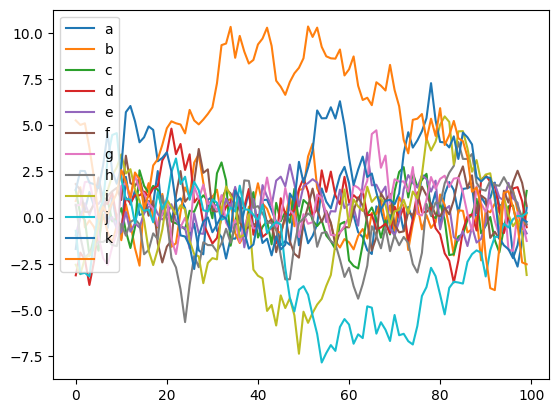

In [4]:
for loc in locations:
    plt.plot(
        obs_data
        .filter(pl.col("location") == loc)
        ["y"],
        label = loc
    )

plt.legend()
plt.show()


In [5]:
def generate_predictions(df, n_samples = 100, horizon = 4):
    predictions = pl.concat([
        pl.concat([
            pl.concat(
                [
                    pl.DataFrame({
                        "location": loc,
                        "population": df.filter(pl.col("location") == loc)["population"][0],
                        "ref_t": df["t"].max(),
                        "output_type": "sample",
                        "output_type_id": range(l_ind * n_samples, (l_ind + 1) * n_samples)
                    }),
                    pl.DataFrame(
                        sim_from_ar(
                            n = n_samples,
                            n_timesteps=horizon,
                            phi=loc_phis[l_ind],
                            tau=1.0,
                            rng=np.random.default_rng(),
                            y_0 = df.filter(pl.col("location") == loc)["y"][-1]
                        )
                    )
                ],
                how='horizontal'
            ) \
            .unpivot(
                on=[f"column_{h}" for h in range(horizon)],
                index=["location", "population", "ref_t", "output_type", "output_type_id"]
            ) \
            .with_columns(
                horizon=pl.col("variable").str.slice(7).cast(int) + 1
            ) \
            .drop("variable")
        ]) \
        for l_ind, loc in enumerate(locations)
    ])
    return predictions

n_samples = 1000
horizon = 12
predictions_time_10 = generate_predictions(obs_data.filter(pl.col("t") <= 10), n_samples=n_samples, horizon=horizon)


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_8253/2272776900.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


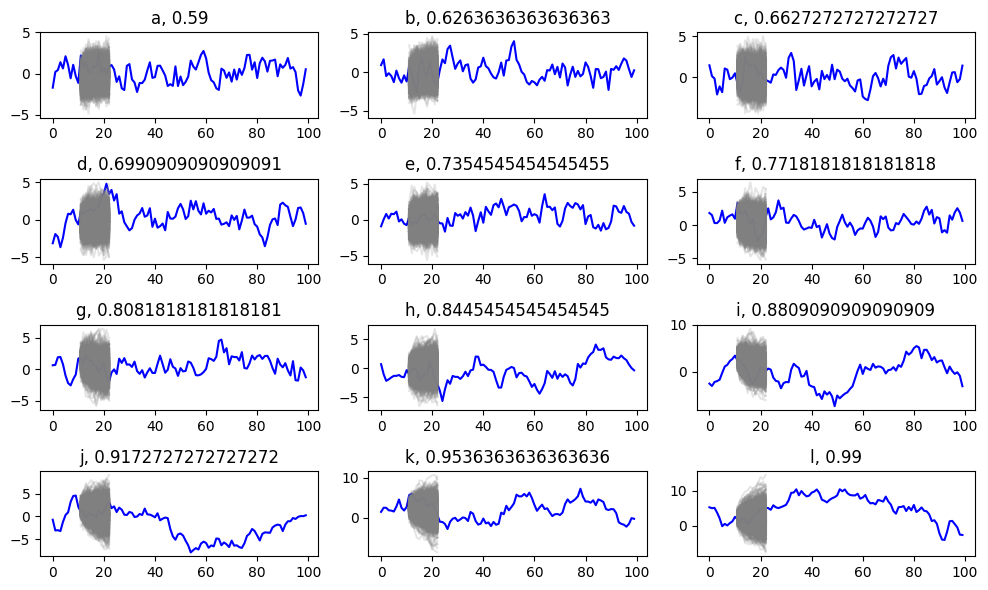

In [6]:
ncol = 3
nrow = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 6))

for i, l, in enumerate(locations):
    row_ind = i // 3
    col_ind = i % 3
    ax[row_ind, col_ind].plot(obs_data.filter(pl.col("location") == l)["y"], c="blue")
    ax[row_ind, col_ind].title.set_text(f"{l}, {loc_phis[i]}")
    loc_preds = (
        predictions_time_10
        .filter(pl.col("location") == l)
        .with_columns(
            target_t = pl.col("ref_t") + pl.col("horizon"),
            idx_within_loc = pl.col("output_type_id") - pl.col("output_type_id").min()
        )
    )
    for j in range(n_samples):
        ax[row_ind, col_ind].plot(
            loc_preds.filter(pl.col("idx_within_loc") == j)["target_t"],
            loc_preds.filter(pl.col("idx_within_loc") == j)["value"],
            c="gray",
            alpha=0.2
        )
        

fig.tight_layout()
fig.show()

In [7]:
horizon = 12
predictions_all_ref_times = pl.concat([
    generate_predictions(obs_data.filter(pl.col("t") <= t), n_samples=n_samples, horizon=horizon) \
        for t in range(n_obs_timesteps)
])
predictions_all_ref_times = predictions_all_ref_times.with_columns(pop_normalized = pl.col("population") / 1000000)

In [8]:
predictions_all_ref_times

location,population,ref_t,output_type,output_type_id,value,horizon,pop_normalized
str,f64,i32,str,i64,f64,i64,f64
"""a""",590000.0,0,"""sample""",0,-1.841184,1,0.59
"""a""",590000.0,0,"""sample""",1,-1.362005,1,0.59
"""a""",590000.0,0,"""sample""",2,-1.492076,1,0.59
"""a""",590000.0,0,"""sample""",3,0.498907,1,0.59
"""a""",590000.0,0,"""sample""",4,-1.388772,1,0.59
…,…,…,…,…,…,…,…
"""l""",990000.0,99,"""sample""",11995,-0.817842,12,0.99
"""l""",990000.0,99,"""sample""",11996,2.279318,12,0.99
"""l""",990000.0,99,"""sample""",11997,3.513283,12,0.99


In [9]:
obs_data = obs_data.with_columns(t = pl.col("t").cast(predictions_all_ref_times["ref_t"].dtype))

In [10]:
# Is energy score sensitive to dependence structure, given fixed marginals?
ss = Schaake(weighter=UnivariateGaussianKernel(h = 1.0))
ss.fit(target_data_train=obs_data, model_out_train=None,
       key_cols=["location"], time_col="t", obs_col="y",
       reference_time_col="ref_t", horizon_col="horizon",
       idx_col="output_type_id", pred_col="value",
       feat_cols=["pop_normalized"])

ss._build_train_X_Y(min_horizon=1, max_horizon=horizon,
                    obs_mask = None)

wide_model_out = ss._pivot_horizon(
    model_out=predictions_all_ref_times
)
energy_score(
    wide_model_out.with_columns(t = pl.col("ref_t").cast(ss.target_data_train["t"].dtype)),
    ss.target_data_train,
    index_cols = ss.key_cols + ["t"],
    pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
    obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
    reduce_mean = True
)

3.915993006818547

In [11]:
wide_model_out_shuffled = (
    wide_model_out
    .with_columns(
        postpredict_horizon1 = pl.col("postpredict_horizon1").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon2 = pl.col("postpredict_horizon2").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon3 = pl.col("postpredict_horizon3").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon4 = pl.col("postpredict_horizon4").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon5 = pl.col("postpredict_horizon5").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon6 = pl.col("postpredict_horizon6").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon7 = pl.col("postpredict_horizon7").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon8 = pl.col("postpredict_horizon8").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon9 = pl.col("postpredict_horizon9").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon10 = pl.col("postpredict_horizon10").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon11 = pl.col("postpredict_horizon11").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon12 = pl.col("postpredict_horizon12").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"])
    )
)

energy_score(
    wide_model_out_shuffled.with_columns(t = pl.col("ref_t").cast(ss.target_data_train["t"].dtype)),
    ss.target_data_train,
    index_cols = ss.key_cols + ["t"],
    pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
    obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
    reduce_mean = True
)

4.017322503011105

In [12]:
n_folds = 5
n_times_per_fold = (n_obs_timesteps - horizon) // n_folds
folds = [
    {"t": list(range(i * n_times_per_fold, (i+1) * n_times_per_fold))} \
        for i in range(n_folds)
]
folds


[{'t': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]},
 {'t': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]},
 {'t': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
 {'t': [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]},
 {'t': [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]}]

In [13]:
reference_time_col = "ref_t"

def get_metric_one_val_fold(ss, pit_templates, model_out, folds, val_fold_ind, metric_fn):
    """
    Obtain predictions for the validation set where the only observations
    used for templates are from outside the validation set.
    """
    val_model_out = model_out.filter(
        pl.col(reference_time_col).is_in(folds[val_fold_ind]["t"])
    )
    
    train_obs_mask = ~obs_data["t"].is_in(folds[val_fold_ind]["t"])
    
    transformed_val_model_out = ss.transform(
        model_out=val_model_out,
        obs_mask=train_obs_mask,
        pit_templates=pit_templates,
        return_long_format=False
    )
    
    metric = metric_fn(
        transformed_val_model_out.with_columns(t = pl.col("ref_t").cast(ss.target_data_train["t"].dtype)),
        ss.target_data_train,
        index_cols = ss.key_cols + ["t"],
        pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
        obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
        reduce_mean = True
    )
    
    return metric


def get_metric_crossval(ss, pit_templates, model_out, folds, metric_fn):
    metrics_by_fold = np.array([
        get_metric_one_val_fold(ss, pit_templates, model_out, folds, val_fold_ind, metric_fn) \
            for val_fold_ind in range(len(folds))
    ])
    print(metrics_by_fold)
    
    return np.mean(metrics_by_fold)


In [14]:
ss = Schaake(weighter=UnivariateGaussianKernel(h = 1.0))
ss.fit(target_data_train=obs_data, model_out_train=predictions_all_ref_times,
       key_cols=["location"], time_col="t", obs_col="y",
       reference_time_col="ref_t", horizon_col="horizon",
       idx_col="output_type_id", pred_col="value",
       feat_cols=["pop_normalized"])

get_metric_crossval(ss=ss, pit_templates=False, model_out=predictions_all_ref_times, folds=folds, metric_fn=energy_score)


[4.05677531 3.62275054 4.44659828 3.71384296 3.92291869]


np.float64(3.9525771547189628)

In [15]:
ss = Schaake(weighter=UnivariateGaussianKernel(h = 1.0))
ss.fit(target_data_train=obs_data, model_out_train=predictions_all_ref_times,
       key_cols=["location"], time_col="t", obs_col="y",
       reference_time_col="ref_t", horizon_col="horizon",
       idx_col="output_type_id", pred_col="value",
       feat_cols=["pop_normalized"])

get_metric_crossval(ss=ss, pit_templates=True, model_out=predictions_all_ref_times, folds=folds, metric_fn=energy_score)


[4.02412083 3.60572725 4.42915042 3.70714029 3.90679127]


np.float64(3.9345860105177777)

In [18]:
def objective(trial):
    h = trial.suggest_float("h", low=1e-6, high=1e2, log=True)
    ss = Schaake(weighter=UnivariateGaussianKernel(h = h))
    ss.fit(target_data_train=obs_data, model_out_train=predictions_all_ref_times,
       key_cols=["location"], time_col="t", obs_col="y",
       reference_time_col="ref_t", horizon_col="horizon",
       idx_col="output_type_id", pred_col="value",
       feat_cols=["pop_normalized"])
    return get_metric_crossval(ss=ss, pit_templates=False, model_out=predictions_all_ref_times, folds=folds, metric_fn=energy_score)

study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2024-10-22 20:37:51,373] A new study created in memory with name: no-name-1a8deea9-15d3-4c8a-a2c0-b09ce7f73317
[I 2024-10-22 20:40:03,691] Trial 0 finished with value: 3.9530882305762822 and parameters: {'h': 1.480938334783115}. Best is trial 0 with value: 3.9530882305762822.


[4.05971879 3.62179184 4.44639756 3.71347581 3.92405715]


[I 2024-10-22 20:42:18,728] Trial 1 finished with value: 3.9623474108546484 and parameters: {'h': 2.6931109441398032e-05}. Best is trial 0 with value: 3.9530882305762822.


[4.03641474 3.64237537 4.44738783 3.73469206 3.95086705]


[I 2024-10-22 20:44:30,419] Trial 2 finished with value: 3.9626196847610466 and parameters: {'h': 1.060844213840139e-06}. Best is trial 0 with value: 3.9530882305762822.


[4.03585287 3.64306984 4.44703645 3.73559626 3.95154301]


[I 2024-10-22 20:46:45,245] Trial 3 finished with value: 3.962428670953404 and parameters: {'h': 2.9555487465245877e-05}. Best is trial 0 with value: 3.9530882305762822.


[4.03708813 3.6428558  4.44629615 3.73525366 3.95064962]


[I 2024-10-22 20:48:59,497] Trial 4 finished with value: 3.9530672811559655 and parameters: {'h': 1.7812042945695725}. Best is trial 4 with value: 3.9530672811559655.


[4.05905784 3.62238123 4.4467993  3.71449332 3.92260471]


[I 2024-10-22 20:51:19,031] Trial 5 finished with value: 3.9619961230243597 and parameters: {'h': 1.5959834137857613e-05}. Best is trial 4 with value: 3.9530672811559655.


[4.03579789 3.6427726  4.44718943 3.73462161 3.94959909]


[I 2024-10-22 20:53:41,631] Trial 6 finished with value: 3.9538952784099015 and parameters: {'h': 97.73307024529294}. Best is trial 4 with value: 3.9530672811559655.


[4.05918587 3.62244496 4.44883714 3.71545739 3.92355103]


[I 2024-10-22 20:55:55,062] Trial 7 finished with value: 3.962666582068839 and parameters: {'h': 1.6121738322581978e-06}. Best is trial 4 with value: 3.9530672811559655.


[4.03785754 3.6414384  4.44739279 3.73557712 3.95106706]


[I 2024-10-22 20:58:08,702] Trial 8 finished with value: 3.9445275580224104 and parameters: {'h': 0.0014001412662377896}. Best is trial 8 with value: 3.9445275580224104.


[4.04658068 3.61630897 4.44155224 3.7100345  3.90816141]


[I 2024-10-22 21:00:20,922] Trial 9 finished with value: 3.9412532119237307 and parameters: {'h': 0.03874706229375828}. Best is trial 9 with value: 3.9412532119237307.


[4.04662206 3.60816949 4.43635072 3.70545703 3.90966676]


In [19]:
study.trials_dataframe()


,number,value,datetime_start,datetime_complete,duration,params_h,state
0,0,3.953088,2024-10-22 20:37:51.374810,2024-10-22 20:40:03.691825,0 days 00:02:12.317015,1.480938,COMPLETE
1,1,3.962347,2024-10-22 20:40:03.692515,2024-10-22 20:42:18.728304,0 days 00:02:15.035789,0.000027,COMPLETE
2,2,3.962620,2024-10-22 20:42:18.729016,2024-10-22 20:44:30.419776,0 days 00:02:11.690760,0.000001,COMPLETE
3,3,3.962429,2024-10-22 20:44:30.420659,2024-10-22 20:46:45.245525,0 days 00:02:14.824866,0.000030,COMPLETE
4,4,3.953067,2024-10-22 20:46:45.246182,2024-10-22 20:48:59.497637,0 days 00:02:14.251455,1.781204,COMPLETE
5,5,3.961996,2024-10-22 20:48:59.498318,2024-10-22 20:51:19.030965,0 days 00:02:19.532647,0.000016,COMPLETE
6,6,3.953895,2024-10-22 20:51:19.031897,2024-10-22 20:53:41.630982,0 days 00:02:22.599085,97.733070,COMPLETE
7,7,3.962667,2024-10-22 20:53:41.631716,2024-10-22 20:55:55.062405,0 days 00:02:13.430689,0.000002,COMPLETE
8,8,3.944528,2024-10-22 20:55:55.063121,2024-10-22 20:58:08.701907,0 days 00:02:13.638786,0.001400,COMPLETE
9,9,3.941253,2024-10-22 20:58:08.702629,2024-10-22 21:00:20.921928,0 days 00:02:12.219299,0.038747,COMPLETE


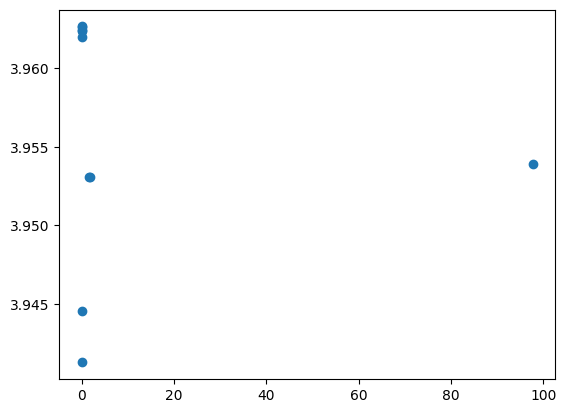

In [20]:
plt.plot(
    study.trials_dataframe()["params_h"],
    study.trials_dataframe()["value"],
    'o'
)

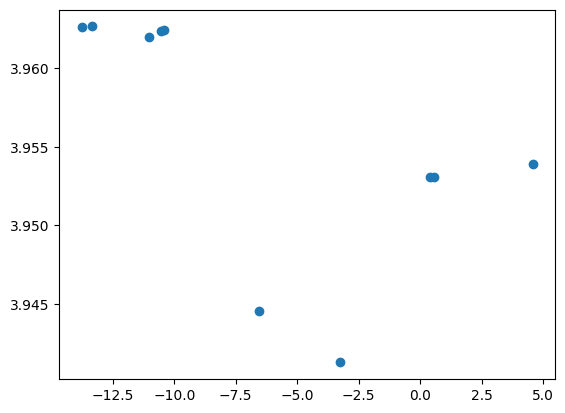

In [21]:
plt.plot(
    np.log(study.trials_dataframe()["params_h"]),
    study.trials_dataframe()["value"],
    'o'
)

In [22]:
def objective_pit_templates(trial):
    h = trial.suggest_float("h", low=1e-6, high=1e2, log=True)
    ss = Schaake(weighter=UnivariateGaussianKernel(h = h))
    ss.fit(target_data_train=obs_data, model_out_train=predictions_all_ref_times,
       key_cols=["location"], time_col="t", obs_col="y",
       reference_time_col="ref_t", horizon_col="horizon",
       idx_col="output_type_id", pred_col="value",
       feat_cols=["pop_normalized"])
    return get_metric_crossval(ss=ss, pit_templates=True, model_out=predictions_all_ref_times, folds=folds, metric_fn=energy_score)

study_pit_templates = optuna.create_study()
study_pit_templates.optimize(objective_pit_templates, n_trials=10)

[I 2024-10-22 21:00:21,200] A new study created in memory with name: no-name-029051f7-dd07-4261-a71c-31c94b1f46aa
[I 2024-10-22 21:02:30,844] Trial 0 finished with value: 3.943048096864858 and parameters: {'h': 0.00045013028577396095}. Best is trial 0 with value: 3.943048096864858.


[4.03033241 3.61773883 4.43406254 3.71760419 3.91550251]


[I 2024-10-22 21:04:43,035] Trial 1 finished with value: 3.9540040583410025 and parameters: {'h': 5.892691451117065e-06}. Best is trial 0 with value: 3.943048096864858.


[4.03755416 3.62959035 4.44423766 3.73052417 3.92811395]


[I 2024-10-22 21:06:54,345] Trial 2 finished with value: 3.9267837045204574 and parameters: {'h': 0.011672297209985812}. Best is trial 2 with value: 3.9267837045204574.


[4.01930032 3.59585404 4.4204826  3.69972457 3.89855699]


[I 2024-10-22 21:09:05,952] Trial 3 finished with value: 3.934247309128698 and parameters: {'h': 0.5458588649003264}. Best is trial 2 with value: 3.9267837045204574.


[4.0233376  3.60584523 4.42818161 3.70659546 3.90727665]


[I 2024-10-22 21:11:16,589] Trial 4 finished with value: 3.92750793613459 and parameters: {'h': 0.007233776757154854}. Best is trial 2 with value: 3.9267837045204574.


[4.02089104 3.59692943 4.42072186 3.70082662 3.89817071]


[I 2024-10-22 21:13:27,065] Trial 5 finished with value: 3.9330610190243376 and parameters: {'h': 0.14811760593080453}. Best is trial 2 with value: 3.9267837045204574.


[4.02178191 3.6035132  4.42677901 3.70676129 3.90646968]


[I 2024-10-22 21:15:38,098] Trial 6 finished with value: 3.934359252731089 and parameters: {'h': 2.134254836948389}. Best is trial 2 with value: 3.9267837045204574.


[4.02260307 3.60647509 4.42913484 3.707213   3.90637026]


[I 2024-10-22 21:17:51,648] Trial 7 finished with value: 3.9300376076754424 and parameters: {'h': 0.05810840806420853}. Best is trial 2 with value: 3.9267837045204574.


[4.01951962 3.60038629 4.42465868 3.70333691 3.90228654]


[I 2024-10-22 21:20:04,464] Trial 8 finished with value: 3.934983860232747 and parameters: {'h': 25.396604753620093}. Best is trial 2 with value: 3.9267837045204574.


[4.02460768 3.60669589 4.42910629 3.70655112 3.90795832]


[I 2024-10-22 21:22:16,824] Trial 9 finished with value: 3.9346964621620373 and parameters: {'h': 16.204112336262103}. Best is trial 2 with value: 3.9267837045204574.


[4.0236139  3.60527489 4.42867849 3.70718103 3.908734  ]


In [23]:
study_pit_templates.trials_dataframe()


,number,value,datetime_start,datetime_complete,duration,params_h,state
0,0,3.943048,2024-10-22 21:00:21.202164,2024-10-22 21:02:30.844081,0 days 00:02:09.641917,0.000450,COMPLETE
1,1,3.954004,2024-10-22 21:02:30.844766,2024-10-22 21:04:43.034901,0 days 00:02:12.190135,0.000006,COMPLETE
2,2,3.926784,2024-10-22 21:04:43.035588,2024-10-22 21:06:54.345672,0 days 00:02:11.310084,0.011672,COMPLETE
3,3,3.934247,2024-10-22 21:06:54.346347,2024-10-22 21:09:05.952824,0 days 00:02:11.606477,0.545859,COMPLETE
4,4,3.927508,2024-10-22 21:09:05.953507,2024-10-22 21:11:16.588976,0 days 00:02:10.635469,0.007234,COMPLETE
5,5,3.933061,2024-10-22 21:11:16.589756,2024-10-22 21:13:27.064980,0 days 00:02:10.475224,0.148118,COMPLETE
6,6,3.934359,2024-10-22 21:13:27.065821,2024-10-22 21:15:38.098781,0 days 00:02:11.032960,2.134255,COMPLETE
7,7,3.930038,2024-10-22 21:15:38.099467,2024-10-22 21:17:51.648211,0 days 00:02:13.548744,0.058108,COMPLETE
8,8,3.934984,2024-10-22 21:17:51.648870,2024-10-22 21:20:04.464137,0 days 00:02:12.815267,25.396605,COMPLETE
9,9,3.934696,2024-10-22 21:20:04.464820,2024-10-22 21:22:16.824373,0 days 00:02:12.359553,16.204112,COMPLETE


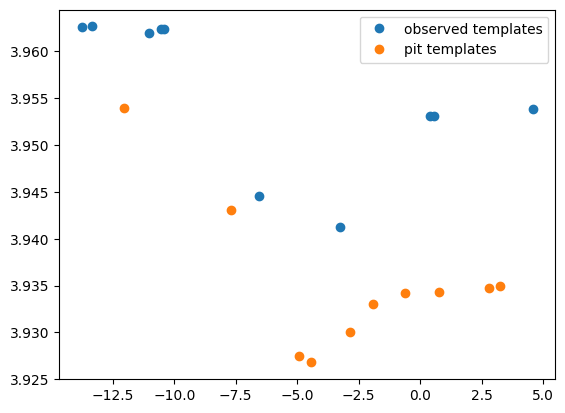

In [25]:
plt.plot(
    np.log(study.trials_dataframe()["params_h"]),
    study.trials_dataframe()["value"],
    'o',
    label='observed templates'
)

plt.plot(
    np.log(study_pit_templates.trials_dataframe()["params_h"]),
    study_pit_templates.trials_dataframe()["value"],
    'o',
    label='pit templates'
)
plt.legend()